# Euclidean Projection onto Unit Balls and Spheres

In this notebook we provide examples of projecting points onto unit $L_p$ [balls and spheres](https://en.wikipedia.org/wiki/Ball_%28mathematics%29) by solving the following constrained optimization problems

$$
\begin{array}{lll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2 \\
    & \text{subject to} & \|u\|_p \leq 1
\end{array}
$$
and
$$
\begin{array}{lll}
    y \in & \text{argmin}_u & \frac{1}{2} \|u - x\|^2 \\
    & \text{subject to} & \|u\|_p = 1
\end{array}
$$
respectively. We consider three balls $p = 2/3, 1, 2$ and $\infty$.


In [44]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from numpy import linalg as LA

def get_hyperplane_projection(point_to_be_projected_act, 
                                            weights_act, 
                                                radius):
    """Gets the hyperplane projection of a given point.
    
    Args:
        point_to_be_projected_act: Point to be projected with positive components.
        weights: the weights vector with positive components
        radius: The radius of weighted l1-ball.
    Returns:
        x_sub : The projection point
    
    """
    
    EPS = np.finfo(np.float64).eps

    numerator = np.inner(weights_act, point_to_be_projected_act) - radius 
    denominator = np.inner(weights_act, weights_act) 
    
    dual = np.divide(numerator, denominator + EPS) # compute the dual variable for the weighted l1-ball projection problem
        
    x_sub = point_to_be_projected_act - dual * weights_act

    return x_sub,dual


def get_weightedl1_ball_projection(point_to_be_projected,
                                   weights, 
                                   radius):
    """Gets the weighted l1 ball projection of given point.
    
    Args:
        point_to_be_projected: Point to be projected.
        weights: the weights vector.
        radius: The radius of weighted l1-ball.
    Returns:
        x_opt : The projection point.
    
    """

    signum = np.sign(point_to_be_projected)
    point_to_be_projected_copy = signum * point_to_be_projected
    
    
    act_ind = [True] * point_to_be_projected.shape[0]
    
    # The loop of the weight l1-ball projection algorithm
    while True:
        # Discarding the zeros 
        point_to_be_projected_copy_act = point_to_be_projected_copy[act_ind]
        weights_act = weights[act_ind]
        
        # Perform projections in a reduced space R^{|act_ind|}
        x_sol_hyper, dual = get_hyperplane_projection(point_to_be_projected_copy_act, weights_act, radius)
        
        # Update the active index set
        point_to_be_projected_copy_act = np.maximum(x_sol_hyper, 0.0)

        point_to_be_projected_copy[act_ind] = point_to_be_projected_copy_act.copy()
        
        act_ind = point_to_be_projected_copy > 0

        inact_ind_cardinality = sum(x_sol_hyper < 0)
        
        # Check the stopping criteria
        if inact_ind_cardinality == 0:
            x_opt = point_to_be_projected_copy * signum
            break

    # gap = radius -  np.inner(weights, abs(x_opt))
    # print(gap)
    return x_opt, dual

def get_lp_ball_projection(starting_point,
                    point_to_be_projected, 
                                        p,
                                   radius, 
                                  epsilon,
                                  Tau = 1.1,
                                  condition_right=100,
                                  tol=1e-8,
                                  MAX_ITER=1000,**kwargs):
    """Gets the lp ball projection of given point.

    Args:
    ----------
    point_to_be_projected: Point to be projected.
    starting_point: Iterates of IRBP.
    p: p parameter for lp-ball.
    radius: The radius of lp-ball.
    epsilon: Initial value of the smoothing parameter epsilon
    Tau, condition_right: hyperparameters
    Returns
    -------
    x_final : The projection point 
    dual : The multiplier
    Flag_gamma_pos : whether IRBP successfully returens a solution
    count : The number of iterations

    """
    if LA.norm(point_to_be_projected, p) ** p <= radius:  
        return point_to_be_projected
    
    # Step 1 and 2 in IRBP.  
    n = point_to_be_projected.shape[0]
            
    signum = np.sign(point_to_be_projected) 
    yAbs = signum * point_to_be_projected  # yAbs lives in the positive orthant of R^n
    
    lamb = 0.0
    residual_alpha0 = (1. / n) * LA.norm((yAbs - starting_point) * starting_point - p * lamb * starting_point ** p, 1)
    residual_beta0 =  abs(LA.norm(starting_point, p) ** p - radius)
    
    cnt = 0
    
    # The loop of IRBP
    while True:
            
        cnt += 1
        alpha_res = (1. / n) * LA.norm((yAbs - starting_point) * starting_point - p * lamb * starting_point ** p, 1)
        beta_res = abs(LA.norm(starting_point, p) ** p - radius)
        
        if max(alpha_res, beta_res) < tol * max(max(residual_alpha0, residual_beta0),\
                                                              1.0) or cnt > MAX_ITER:
            x_final = signum * starting_point # symmetric property of lp ball
            break
        
            
        # Step 3 in IRBP. Compute the weights
        weights = p * 1. / ((np.abs(starting_point) + epsilon) ** (1 - p) + 1e-12)
        
        # Step 4 in IRBP. Solve the subproblem for x^{k+1}
        gamma_k = radius - LA.norm(abs(starting_point) + epsilon, p) ** p + np.inner(weights, np.abs(starting_point))
            
        assert gamma_k > 0, "The current Gamma is non-positive"
         
        # Subproblem solver : The projection onto weighted l1-ball
        x_new, lamb = get_weightedl1_ball_projection(yAbs, weights, gamma_k)
        x_new[np.isnan(x_new)] = np.zeros_like(x_new[np.isnan(x_new)])
            
        # Step 5 in IRBP. Set the new relaxation vector epsilon according to the proposed condition
        condition_left = LA.norm(x_new - starting_point, 2) * LA.norm(np.sign(x_new - starting_point) * weights, 2) ** Tau
            
        if condition_left <= condition_right:
            theta = np.minimum(beta_res, 1. / np.sqrt(cnt)) ** (1. / p)
            epsilon = theta * epsilon
            
        # Step 6 in IRBP. Set k <--- (k+1)
        starting_point = x_new.copy()
    return  x_final

In [45]:
import numpy as np


def insideBall(x, p=2):
    """Returns true if point x is inside a unit Lp ball."""
    return np.linalg.norm(x, p) <= 1.0


def euclideanProjection(x, p=2):
    """Projects the point x onto the unit Lp sphere."""
    if insideBall(x,p):
        return x
    if (p == 1):
        mu = np.sort(np.abs(x))[::-1]
        mu_sum = mu.cumsum()
        rho = np.max([j for j in range(len(mu)) if ((j + 1) * mu[j] > mu_sum[j] - 1.0)])
        theta = (mu_sum[rho] - 1.0) / (rho + 1)
        w = np.maximum(np.abs(x) - theta, 0.0)
        return w * [1.0 if xi >= 0 else -1.0 for xi in x]
    if (p == 2):
        return x / np.sqrt(np.dot(x, x))
    if (p == np.inf):
        w = np.minimum(np.maximum(x, -1.0), 1.0)
        if np.all(np.abs(w) < 1.0):
            rho = np.argmin(1.0 - np.abs(w))
            w[rho] = np.sign(w[rho])
        return w
    if (p>0 and p<1):
        return get_lp_ball_projection(np.zeros_like(x),x,p,1,1e-4)
    
    assert False, "unrecognized p={}".format(p)
    return None


We now animate projection onto different unit spheres as a function of $x$ for the 2-dimensional point $(x, 0.5)$ shown as the black dot. The red, blue and green dots represent the nearest points to $(x, 0.5)$ on the $L_p$-, $L_1$-, $L_2$- and $L_\infty$-spheres, respectively.

In [46]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


x = np.linspace(-3.0, 3.0, num=101)
y_1, y_2, y_inf, y_p = [], [], [], []

for xi in x:
    y_1.append(euclideanProjection([xi, 0.5], 1))
    y_2.append(euclideanProjection([xi, 0.5], 2))
    y_inf.append(euclideanProjection([xi, 0.5], np.inf))
    y_p.append(euclideanProjection(np.array([xi, 0.5]), 2/3))
    
def animate(fnum, x, y_1, y_2, y_inf,y_p):

    # draw balls
    ax.clear()
    ax.plot([0.0, 1.0, 0.0, -1.0, 0.0], [1.0, 0.0, -1.0, 0.0, 1.0], 'r', linewidth=1)
    ax.plot(np.cos(np.linspace(0.0, 2.0 * np.pi)), np.sin(np.linspace(0.0, 2.0 * np.pi)), 'b', linewidth=1)
    xp = np.cos(np.linspace(0.0, 2.0 * np.pi))**3
    yp = np.sin(np.linspace(0.0, 2.0 * np.pi))**3
    ax.plot(xp, yp, 'y', linewidth=1)
    ax.plot([-1.0, 1.0, 1.0, -1.0, -1.0], [1.0, 1.0, -1.0, -1.0, 1.0], 'g', linewidth=1)
    
    # draw path for x
    ax.plot([x[0], x[-1]], [0.5, 0.5], 'k--')
    ax.plot(x[fnum], 0.5, 'ko')
    
    # draw projection
    ax.plot(y_1[fnum][0], y_1[fnum][1], 'ro')
    ax.plot(y_2[fnum][0], y_2[fnum][1], 'bo')
    ax.plot(y_inf[fnum][0], y_inf[fnum][1], 'go')
    ax.plot(y_p[fnum][0], y_p[fnum][1], 'yo')
    
    ax.set_xlim(x[0], x[-1]); ax.set_ylim(x[0], x[-1])
    ax.axis('equal')
    return (ax,)


fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ani = animation.FuncAnimation(fig, animate, init_func=None, fargs=(x, y_1, y_2, y_inf, y_p),
                              interval=100, frames=len(x), blit=False, repeat=False)
plt.close(fig)

In [47]:
#HTML(ani.to_jshtml())
HTML(ani.to_html5_video())

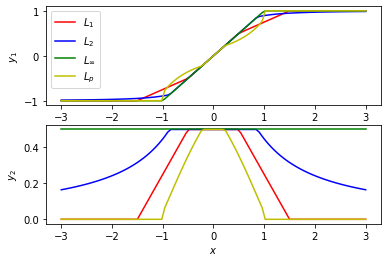

In [48]:
%matplotlib inline
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, [yi[0] for yi in y_1], 'r')
plt.plot(x, [yi[0] for yi in y_2], 'b')
plt.plot(x, [yi[0] for yi in y_inf], 'g')
plt.plot(x, [yi[0] for yi in y_p], 'y')
plt.ylabel(r"$y_1$"); plt.legend([r"$L_1$", r"$L_2$", r"$L_\infty$",r"$L_p$"])

plt.subplot(2, 1, 2)
plt.plot(x, [yi[1] for yi in y_1], 'r')
plt.plot(x, [yi[1] for yi in y_2], 'b')
plt.plot(x, [yi[1] for yi in y_inf], 'g')
plt.plot(x, [yi[1] for yi in y_p], 'y')
plt.xlabel(r"$x$"); plt.ylabel(r"$y_2$")

plt.show()
